In [1]:
import numpy	as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp

In [2]:
datos = pd.read_csv('data.csv')
magnitud = datos.iloc[:, 0]
funcionlum = datos.iloc[:, 1]

In [3]:
def	schechter(x,M,phi,alpha):
				m = 0.4*np.log(10)*phi*(10**(-0.4*(x-M)*(alpha+1)))*np.exp(-10**(-0.4*(x-M)))
				return m

Derivo con python para evitar errores humanos

In [4]:
x, M, phi, alpha = sp.symbols('x M phi alpha')
m_sympy = 0.4*sp.log(10)*phi*(10**(-0.4*(x-M)*(alpha+1)))*sp.exp(-10**(-0.4*(x-M)))
derivadaM = sp.diff(m_sympy, M)
derivadaphi = sp.diff(m_sympy, phi)
derivadaalpha = sp.diff(m_sympy, alpha)
print(derivadaM)
print(derivadaphi)
print(derivadaalpha)

-0.16*10**((0.4*M - 0.4*x)*(alpha + 1))*10**(0.4*M - 0.4*x)*phi*exp(-10**(0.4*M - 0.4*x))*log(10)**2 + 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*alpha + 0.4)*exp(-10**(0.4*M - 0.4*x))*log(10)**2
0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*exp(-10**(0.4*M - 0.4*x))*log(10)
0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*M - 0.4*x)*exp(-10**(0.4*M - 0.4*x))*log(10)**2


In [5]:
fiducial_M = -20.83
fiducial_phi = 1.46e-2
fiducial_alpha = -1.2

alphamin = fiducial_alpha*(1+0.1)
alphamax = fiducial_alpha*(1-0.1)
Mmin = fiducial_M*(1+0.1)
Mmax = fiducial_M*(1-0.1)
phimin = fiducial_phi*(1-0.2)
phimax = fiducial_phi*(1+0.2)
print(alphamin, alphamax, Mmin, Mmax, phimin, phimax)

def loglike(x, y, M, phi, alpha, sigma):
				m = schechter(x, M, phi, alpha)
				L = -(1/2) * np.sum(((y - m) / sigma) ** 2)
				return L

bordeinferr =	np.array([Mmin, phimin, alphamin])
bordesuperr = np.array([Mmax, phimax, alphamax])

def priors(params):
	if np.all(bordeinferr <= params) and np.all(params <= bordesuperr):
		return 0
	else:
		return -np.inf
	

def post(x, y, M, phi, alpha, sigma):
	params = np.array([M, phi, alpha])
	prior_prob = priors(params)
	return loglike(x, y, M, phi, alpha, sigma) + prior_prob

def normM(M):
    return (M - Mmin) / ( Mmax - Mmin)

def anti_normM(M):
				return (M * (Mmax - Mmin)) + Mmin

def normphi(phi):
				return (phi - phimin) / (phimax - phimin)

def anti_normphi(phi):
				return (phi * (phimax - phimin)) + phimin

def normalpha(alpha):
				return (alpha - alphamin) / (alphamax - alphamin)

def anti_normalpha(alpha):
				return (alpha * (alphamax - alphamin)) + alphamin

-1.32 -1.08 -22.913 -18.747 0.011680000000000001 0.01752


Definimos las funciones

In [6]:
def diffM(x,	M, phi, alpha):
				return -0.16*10**((0.4*M - 0.4*x)*(alpha + 1))*10**(0.4*M - 0.4*x)*phi*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)**2 + 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*alpha + 0.4)*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)**2


def diffphi(x,	M, phi, alpha):
				return 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)

def diffalpha(x,	M, phi, alpha):
				return 0.4*10**((0.4*M - 0.4*x)*(alpha + 1))*phi*(0.4*M - 0.4*x)*np.exp(-10**(0.4*M - 0.4*x))*np.log(10)**2

def gradiente(x, M, phi, alpha, sigma):
				grad = np.zeros(3)
				grad[0] = -2*np.sum((funcionlum-schechter(magnitud, M, phi, alpha))*diffM(magnitud, M, phi, alpha)/(sigma**2))
				grad[1] = -2*np.sum((funcionlum-schechter(magnitud, M, phi, alpha))*diffphi(magnitud, M, phi, alpha)/(sigma**2))
				grad[2] = -2*np.sum((funcionlum-schechter(magnitud, M, phi, alpha))*diffalpha(magnitud, M, phi, alpha)/(sigma**2))
				return grad

Ahora si, el descenso por el gradiente

In [7]:
def graddes(x, y, sigma, N):
	#Lanzamos en un lugar al azar dentro de los priors.
	M = np.random.uniform(Mmin, Mmax)
	phi = np.random.uniform(phimin, phimax)
	alpha = np.random.uniform(alphamin, alphamax)
	#Armamos las listas donde guardaremos todo
	Mreccorridos	= np.zeros(N+1)
	phirecorridos = np.zeros(N+1)
	alpharecorridos = np.zeros(N+1)
	probrecorridas = np.zeros(N+1)
	#Guardamos los primeros valores
	Mreccorridos[0] = M
	phirecorridos[0] = phi
	alpharecorridos[0] = alpha
	probrecorridas[0] = post(x, y, M, phi, alpha, sigma)
	#Empezamos a recorrer
	for i in range(N):
		if i<N/10:
			pp = 1e-2
		elif i<(2*N/10):
			pp =	1e-3
		else:
			pp = 1e-4

		#Calculamos el gradiente y lo normalizamos
		grad =	gradiente(x, M, phi, alpha, sigma)
		gradnorm	= np.zeros(3)
		for j in range(3):
			gradnorm[j]	= grad[j]/np.sqrt(grad[0]**2 + grad[1]**2 + grad[2]**2)
		
		M_paso = normM(M) - gradnorm[0]*pp
		phi_paso = normphi(phi) - gradnorm[1]*pp
		alpha_paso = normalpha(alpha) - gradnorm[2]*pp
		
		#Ahora, desonormalizamos para calcular la probabilidad:
		M_paso = anti_normM(M_paso)
		phi_paso = anti_normphi(phi_paso)
		alpha_paso = anti_normalpha(alpha_paso)
		probrecorridas[i+1] = post(x, y, M_paso, phi_paso, alpha_paso, sigma)
	#Me los guardo en la lista
		Mreccorridos[i+1] = M_paso
		phirecorridos[i+1] = phi_paso
		alpharecorridos[i+1] = alpha_paso
		#Avanzo
		M = M_paso
		phi = phi_paso
		alpha = alpha_paso
	#Obtengo todos los valores de los parametros
	return	Mreccorridos, phirecorridos, alpharecorridos, probrecorridas

In [8]:
erromin = datos.iloc[:,2]
erromax = datos.iloc[:,3]

sigma = (erromax-erromin) / 2

# Ejecutar el descenso por gradiente
mrec, phirec, alpharec, p = graddes(magnitud, funcionlum, sigma, 10000)

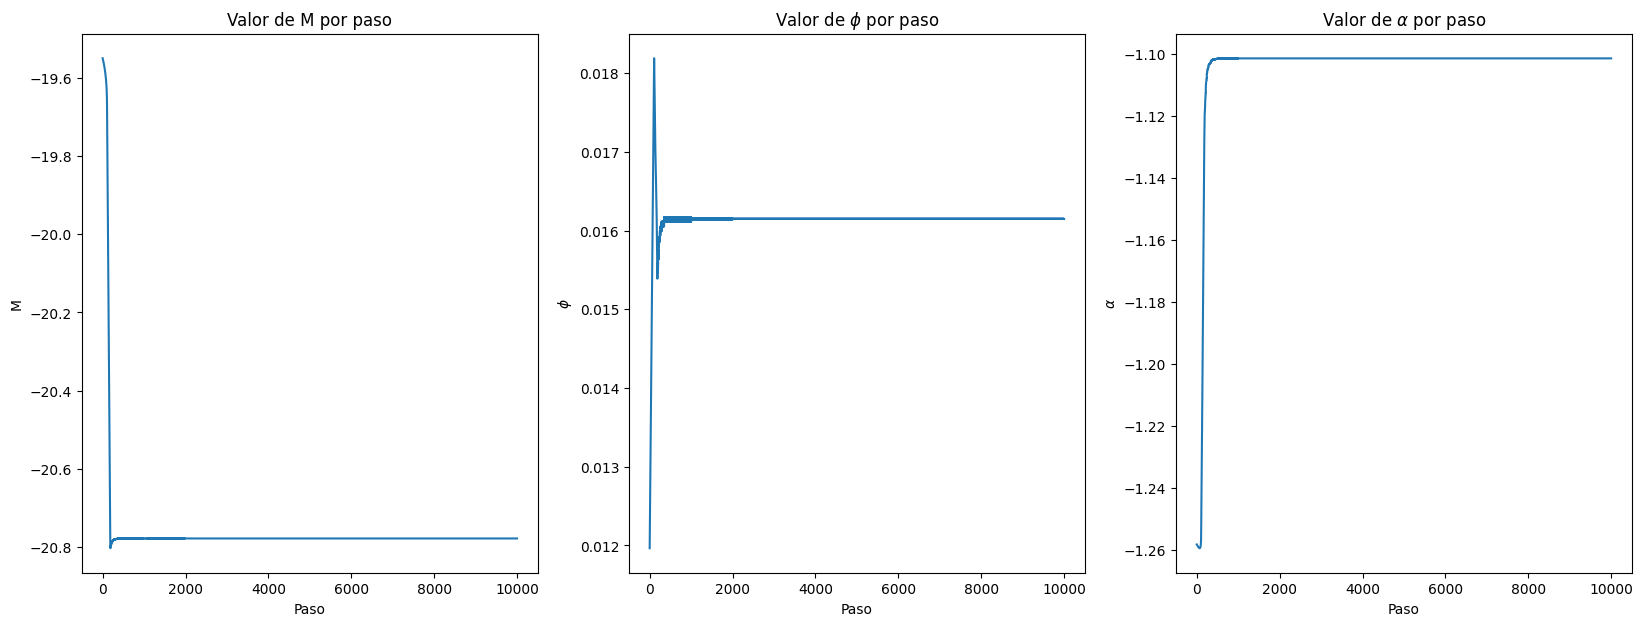

[-537427.03936717 -534336.15668897 -531267.59532641 ...   -5518.764423
   -5518.76728182   -5518.764423  ]
-20.777898841605477 0.016148976079444773 -1.1013393511886516
7.816584240366626e-13 1.9044384802339573e-15 1.0715720347501956e-15


In [9]:
f, axs = plt.subplots(1, 3, figsize=(20, 7))

#Valor por cada paso
axs[0].plot(mrec)
axs[0].set_xlabel('Paso')
axs[0].set_ylabel('M')
axs[0].set_title('Valor de M por paso')

axs[1].plot(phirec)
axs[1].set_xlabel('Paso')
axs[1].set_ylabel('$\phi$')
axs[1].set_title('Valor de $\phi$ por paso')

axs[2].plot(alpharec)
axs[2].set_xlabel('Paso')
axs[2].set_ylabel('$\\alpha$')
axs[2].set_title('Valor de $\\alpha$ por paso')

plt.show()
print(p)

Mmed = np.mean(mrec[-8000:])
phimed = np.mean(phirec[-8000:])
alphamed = np.mean(alpharec[-8000:])
print(Mmed, phimed, alphamed)

Mvari	= np.var(mrec[-8000:])
phivari = np.var(phirec[-8000:])
alphavari = np.var(alpharec[-8000:])

Merror = Mvari/np.sqrt(8000)
phierror = phivari/np.sqrt(8000)
alphaerror = alphavari/np.sqrt(8000)
print(Merror, phierror, alphaerror)


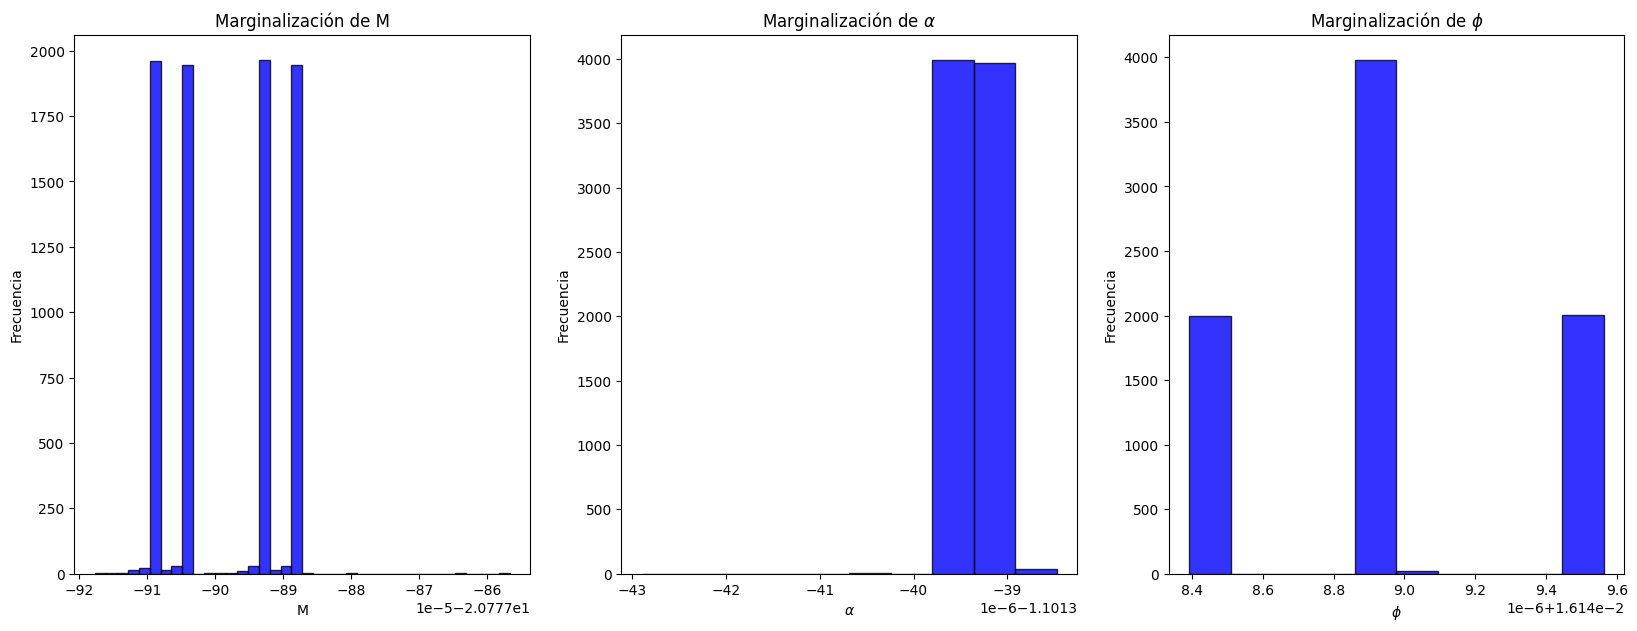

In [10]:
f, axs = plt.subplots(1, 3, figsize=(20, 7))

# Histograma de M
axs[0].hist(mrec[-8000:], color='blue', alpha=0.8, edgecolor='black', bins='auto')
axs[0].set_xlabel('M')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Marginalización de M')

# Histograma de alpha
axs[1].hist(alpharec[-8000:], color='blue', alpha=0.8, edgecolor='black')
axs[1].set_xlabel('$\\alpha$')
axs[1].set_ylabel('Frecuencia')
axs[1].set_title('Marginalización de $\\alpha$')

# Histograma de phi
axs[2].hist(phirec[-8000:], color='blue', alpha=0.8, edgecolor='black')
axs[2].set_xlabel('$\phi$')
axs[2].set_ylabel('Frecuencia')
axs[2].set_title('Marginalización de $\phi$')

plt.show()
